# Tutorial 1: How to use abcTau package to fit autocorrelations or PSDs

Details of the method are explained in:   
Zeraati, R., Engel, T. A. & Levina, A. Estimation of autocorrelation timescales with Approximate Bayesian Computations. bioRxiv 2020.08.11.245944 (2020). https://www.biorxiv.org/content/10.1101/2020.08.11.245944v1

To start you need to have:
Python >= 3.7.1,
Numpy >= 1.15.4 ,
Scipy >= 1.1.0. 

and for visualizations:
Matplotlib >= 3.0.2,
Seaborn >= 0.9.0 

You can install seaborn from https://seaborn.pydata.org/installing.html 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

import numpy as np
from scipy import stats

# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
import abcTau


# graphical properties for figures
sns.set_context('talk',font_scale= 1.5)
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8" 
plt.rcParams.update({'font.size': 12})

## Step 1: extracting required statistics from real data

First load your data and use "extract_stats" functions to compute statistics.

In [2]:
#---------- load real data  (OU process with one timescale)
dataload_path = 'example_data/'
filename = 'OU_tau20_T1000_trials500_deltaT1_data_mean0_data_var1'
data_load = np.load(dataload_path + filename + '.npy')

#---------- extract statistics from real data
# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 100 # only used when suing autocorrelation for summary statistic s
lm = round(maxTimeLag/binSize) # maximum bin for autocorrelation computation
data_ac, data_mean, data_var, T, numTrials = abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

# Step 2 (optional): check the bias in timescales estimated from exponential fits (preprocessing module)

In [3]:
gt_tau = 20 # ground-truth timescale

# fit 
popt, poptcov = abcTau.preprocessing.fit_oneTauExponential(data_ac, binSize, maxTimeLag)
tau = popt[1]

# check if estimated timescales with exponential fit are biased or not
theta = np.array([tau])
numTimescales = 1
taus = abcTau.preprocessing.check_expEstimates(theta, deltaT, binSize, T, numTrials, data_mean, data_var,\
                              maxTimeLag, numTimescales, numIter = 100, confidence_level = 0.05)

Estimates for tau are significantly biased!


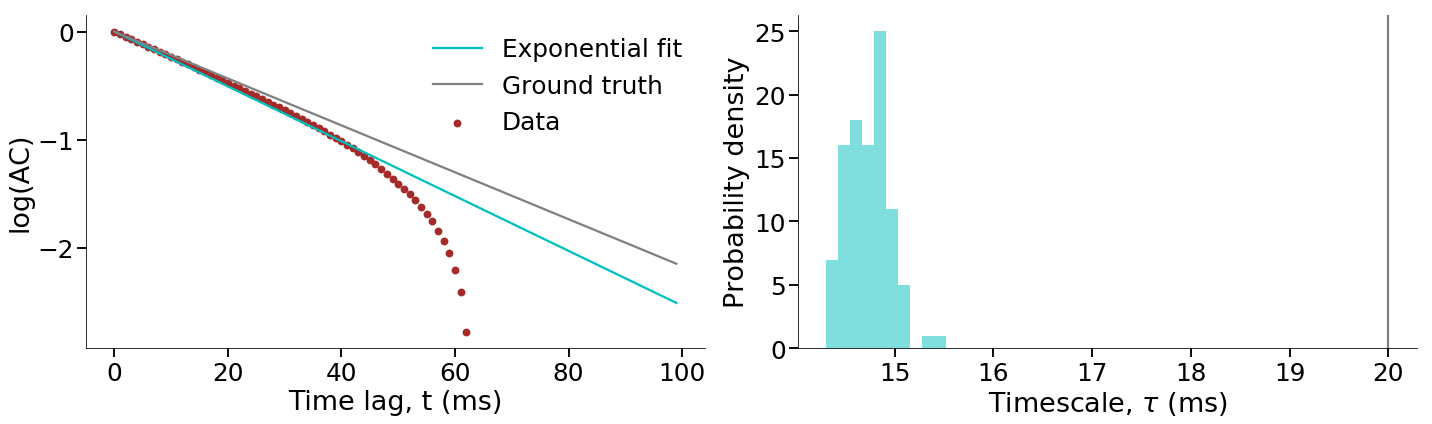

In [4]:
# visualize the results
fig = plt.figure(figsize = (20,6))
ss = 40

ax = plt.subplot(121)
ac = data_ac
binLags = np.arange(0, maxTimeLag, binSize)
ax.scatter(binLags[ac>0],np.log10(ac[ac>0]) ,label='Data', s = ss, color = 'brown')
ax.plot(binLags,np.log10(np.exp(-binLags/tau)) ,label='Exponential fit', color  = 'c')
ax.plot(binLags,np.log10(np.exp(-binLags/gt_tau)) ,label='Ground truth', color  = 'gray')
ax.set_xlabel(r'Time lag, t (ms)')
ax.set_ylabel(r'log(AC)')
ax.legend(frameon = False, loc = 'upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 

ax = plt.subplot(122)
plt.hist(taus, alpha = 0.5, color  = 'c',label='Exponential fit')
plt.axvline(gt_tau, color = 'gray',label='Ground truth')
ax.set_xlabel(r'Timescale, $\tau$ (ms)')
ax.set_ylabel(r'Probability density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

# Step 3: Write a python script to fit autocorrelations with the aABC algorithm

Example scripts are available in "example_scripts" folder.

In the following, we explain how to write your own script from scratch step-by-step:

### [1]  Fitting a general type of generative model in the time domain:
1) import the package and set the parameters for parallel processing (if applicable):

In [4]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 

2) Define the directories and filenames for loading the data and saving the results

In [5]:
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'

# define filename for loading and saving the results
filename = 'OU_tau20_mean0_var1_rawData'
filenameSave = filename

3) Load the real data and extract required statistics

In [6]:
# load data time-series as a numpy array (numTrials * time-points)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 50 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

4) Define the prior distributions

In [7]:
# Define a uniform prior distribution over the given range
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

5) Select the desired generative model from the list of 'generative_models.py' and the distance function from 'diatance_functions.py'

In [8]:
# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'

6) Set the aABC fitting parameters

In [9]:
# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

7) Create the model object: Just copy paste the following (this a general definition of the model object, but all parts including generative models, summary statistics computation or distance function can be replaced by your own functions. You can add your handmade functions inside respected modules: "generative_models.py", "distance_functions.py", "summary_stats.py")

In [10]:
# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

8) Run the aABC algorithm and save the results

In [12]:
# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

Done :) 

Just copy paste the content of all the above cells in a text file and rename it to "scriptName.py"

Then, run it from terminal as: python scriptName.py

### [2]  Fitting a general type of generative model in the frequency domain:

Depending on your application you can also use the aABC method to extract timescales and other parameters from the frequency domain by fitting the sample power spectrum density (PSD).

For this purpose, we use exactly the same script as for the time domain, and only replace the autocorrelation computation with PSD computation.

### Attention! You should use exactly the same method for computing the PSD of real data and synthetic data!

We have implemented a simple PSD estimation function in the abcTau package but depending on your application, you can replace it with any other method such as methods avaiable in Scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

However, the result of aABC algorithm generally does not depend on the choise of PSD computation method, as long as the same method is used for both real and synthetic data.

In [2]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results_psd'

# load real data and define filenameSave
filename = 'OU_tau20_mean0_var1_rawData'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# load data time-series as a numpy array (numTrials * time-points)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_psd'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = None # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)



# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 300.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]


# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'logarithmic_distance'


# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d


# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

OU_tau20_mean0_var1_rawData
Starting step 0
epsilon = 1
acceptence Rate = 0.15822784810126583
--------------------
Starting step 1
epsilon = 0.6835521896878167
acceptence Rate = 0.6211180124223602
--------------------
Starting step 2
epsilon = 0.5166685396270669
acceptence Rate = 0.6622516556291391
--------------------
Starting step 3
epsilon = 0.28619847165768064
acceptence Rate = 0.49019607843137253
--------------------
Starting step 4
epsilon = 0.14348454236437044
acceptence Rate = 0.4975124378109453
--------------------
Starting step 5
epsilon = 0.07686421298638392
acceptence Rate = 0.49019607843137253
--------------------
Starting step 6
epsilon = 0.04548539521268534
acceptence Rate = 0.5128205128205128
--------------------
Starting step 7
epsilon = 0.02775990244460525
acceptence Rate = 0.5649717514124294
--------------------
Starting step 8
epsilon = 0.01535417720311035
acceptence Rate = 0.5780346820809249
--------------------
Starting step 9
epsilon = 0.011175120071844239
accept

KeyboardInterrupt: 

### [3] Fitting the specific case of a two-timescales generative model in the time domain:

We developed a bit different function for fitting the two-timescales generative models to help them converge faster. While you always can use the above script for all models, the following options might help to speed up the fitting when your model have two timescales.

1) define directories and prepare the model object same as above:

In [1]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'


# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t1_min = 0.0 # first timescale
t1_max = 60.0
t2_min = 20.0 # second timescale
t2_max = 140.0
coef_min = 0.0 # coeffiecient or weight of the first timescale
coef_max = 1.0
priorDist = [stats.uniform(loc= t1_min, scale = t1_max - t1_min),\
             stats.uniform(loc= t2_min, scale = t2_max - t2_min),\
             stats.uniform(loc= coef_min, scale = coef_max - coef_min)] 


# select generative model and distance function
generativeModel = 'twoTauOU_poissonSpikes'
distFunc = 'linear_distance'


# load real data and define filenameSave
filename = 'inhomPois_tau5_80_coeff04_T1000_trials500_deltaT1_data_mean1_data_var1.25'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 110 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)



# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

inhomPois_tau5_80_coeff04_T1000_trials500_deltaT1_data_mean1_data_var1.25


2) But instead use the following function for fitting:

In [2]:
# fit with aABC algorithm for the two-timescales generative model
abc_results, final_step = abcTau.fit.fit_withABC_2Tau(MyModel, data_sumStat, priorDist, inter_save_direc,\
                                                      inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

Starting step 0
epsilon = 1
acceptence Rate = 1.0
--------------------
Starting step 1
epsilon = 0.0005858813291678351
acceptence Rate = 0.5128205128205128
--------------------
Starting step 2
epsilon = 0.0004245701708063044
acceptence Rate = 0.4878048780487805
--------------------
Starting step 3
epsilon = 0.00034008215919916266
acceptence Rate = 0.4149377593360996
--------------------
Starting step 4
epsilon = 0.0002962679216505827
acceptence Rate = 0.373134328358209
--------------------
Starting step 5
epsilon = 0.00026046431869343955
acceptence Rate = 0.3436426116838488
--------------------
Starting step 6
epsilon = 0.00021547624950538676
acceptence Rate = 0.31446540880503143
--------------------
Starting step 7
epsilon = 0.00018719023355412434


KeyboardInterrupt: 

# Resuming a previous aABC fit and let it run for more iterations 

It's possible to resume a previous fit with the aABC method and allow it to run from the point it stopped. This functionality is useful when the initial stopping criterion (e.g., minimum acceptance rate) was not sufficient to obtain narrow posteriors and you need better statistics for the fits without running the aABC fit from the beginning.

In [1]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats
# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2"
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
# os.environ["NUMEXPR_NUM_THREADS"] = "2"
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'

# load real data and define filenameSave
filename = 'OU_tau20_T1000_trials500_deltaT1_data_mean0_data_var1'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 50 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)


# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]


# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

OU_tau20_T1000_trials500_deltaT1_data_mean0_data_var1


In [3]:
# load the previous aABC fit
data_abc_path = 'example_abc_results/'
filename = '1on_OU_tau20_T1000_lag50_steps43'
abc_results = np.load(data_abc_path + filename + '.npy', allow_pickle=True)
ind = filename.find('steps') 
final_step = int(filename[ind+5] + filename[ind+6])
abc_results_old = abc_results[:final_step]

# set new fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.005 # new minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

In [9]:
# resume the aABC fitting
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc,\
                                                             inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp, resume = abc_results_old)